# Experiment 1

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from matplotlib import pyplot as plt

## CNN Training

In [2]:
def dataset_prep():
    mnist = tf.keras.datasets.mnist

    (data_train, label_train), (data_test, label_test) = mnist.load_data()
    # # # Normalize 0 to 255 value matrix to 0 to 1 value matrix
    # data_train, data_test = data_train/255.0, data_test/255.0
    train_data = data_train.reshape(data_train.shape[0], 28, 28, 1)
    train_label = np.asarray(label_train, dtype=np.int32)
    test_data = data_test.reshape(data_test.shape[0], 28, 28, 1)
    test_label = np.asarray(label_test, dtype=np.int32)

    return train_data, train_label, test_data, test_label

In [3]:
def lenet5():
    model = tfk.models.Sequential([
        tfk.layers.Conv2D(filters=6, kernel_size=(5, 5), activation=tf.nn.relu, input_shape=(28, 28, 1)),
        tfk.layers.MaxPool2D(pool_size=(2, 2), strides=2),
        tfk.layers.Conv2D(filters=16, kernel_size=(5, 5), activation=tf.nn.relu),
        tfk.layers.MaxPool2D(pool_size=(2, 2), strides=2),
        tfk.layers.Flatten(),
        tfk.layers.Dense(120, activation=tf.nn.relu),
        tfk.layers.Dense(84, activation=tf.nn.relu),
        tfk.layers.Dense(10, activation=tf.nn.softmax),
    ])

    model.compile(optimizer=tfk.optimizers.Adadelta(), loss=tfk.losses.sparse_categorical_crossentropy,
                  metrics=[tfk.metrics.sparse_categorical_accuracy])

    return model

In [4]:
# Create checkpoint callback
checkpoint_path = "/home/Tensorflow_Image_Classification/training_1/lenet5.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1,
                                                 save_best_only=True)

In [5]:
train_data, train_label, test_data, test_label = dataset_prep()
model = lenet5()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               30840     
_________________________________________________________________
dens

In [6]:
model.fit(train_data, train_label, epochs=10, validation_data=(test_data, test_label), callbacks=[cp_callback])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
59712/60000 [============================>.] - ETA: 0s - loss: 0.4829 - sparse_categorical_accuracy: 0.9215
Epoch 00001: val_loss improved from inf to 0.10029, saving model to /home/Tensorflow_Image_Classification/training_1/lenet5.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.
60000/60000 [==============================] - 5s 83us/sample - loss: 0.4811 - sparse_categorical_accuracy: 0.9217 - val_loss: 0.1003 - val_sparse_categorical_accuracy: 0.9680
Epoch 2/10
59680/60000 [============================>.] - ETA: 0s - loss: 0.0746 - sparse_categorical_accuracy: 0.9783
Epoch 00002: val_loss improved from 0.10029 to 0.06352, saving model to /home/Tensorflow_Image_Classification/training_1/lenet5.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
60000/60000 [==================

In [7]:
model.evaluate(test_data, test_label)

10000/10000 [==============================] - 0s 26us/sample - loss: 0.0692 - sparse_categorical_accuracy: 0.9871


[0.06915697224572287, 0.9871]

## Layers study

In [8]:
layer_outputs = [layer.output for layer in model.layers[:12]]
activation_model = tfk.models.Model(inputs=model.input, outputs=layer_outputs)

A hack to see kernel value

In [117]:
target_img = np.arange(784).reshape(28,28,1)

In [129]:
target_img = test_data[250]

In [130]:
target_img.shape

(28, 28, 1)

In [131]:
test_data_tp = np.transpose(target_img, (1,0,2))

In [132]:
test_img = np.hstack(test_data_tp)

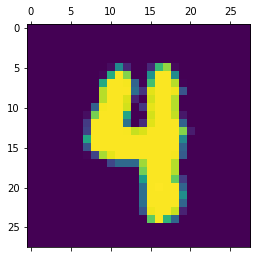

In [133]:
plt.matshow(test_img)

In [134]:
img_tensor = np.expand_dims(target_img, axis=0)

In [135]:
img_tensor.shape

(1, 28, 28, 1)

In [136]:
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]

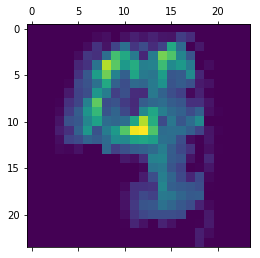

In [138]:
plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis')

In [139]:
layer_names = []
for layer in model.layers[:4]:
    layer_names.append(layer.name)

In [140]:
fmaps_pool = []
for layer_name, layer_activation in zip(layer_names, activations):
    print("name: {0}\nactivation: {1}".format(layer_name, layer_activation.shape))
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    for fmaps in layer_activation:
        fmapsT = np.transpose(fmaps, (2, 0, 1))
        print("feature_maps_shape: {}".format(fmapsT.shape))
        fmap_layer = []
        for fmapT in fmapsT:
            fmap_layer.append(fmapT)
        fmaps_pool.append(fmap_layer)

name: conv2d
activation: (1, 24, 24, 6)
feature_maps_shape: (6, 24, 24)
name: max_pooling2d
activation: (1, 12, 12, 6)
feature_maps_shape: (6, 12, 12)
name: conv2d_1
activation: (1, 8, 8, 16)
feature_maps_shape: (16, 8, 8)
name: max_pooling2d_1
activation: (1, 4, 4, 16)
feature_maps_shape: (16, 4, 4)


(24, 144)
(12, 72)
(8, 128)
(4, 64)


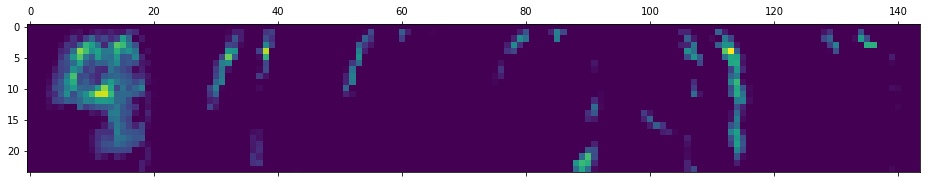

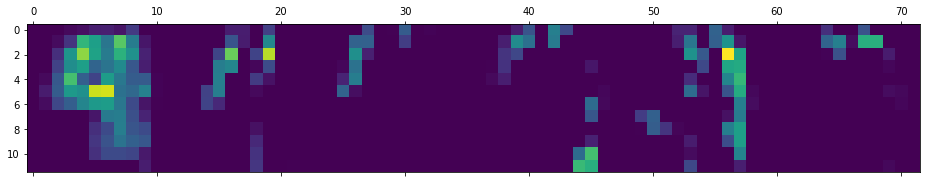

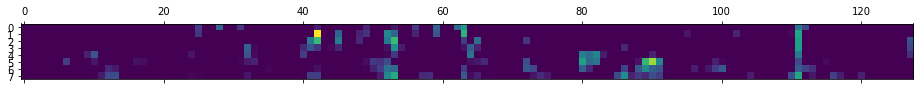

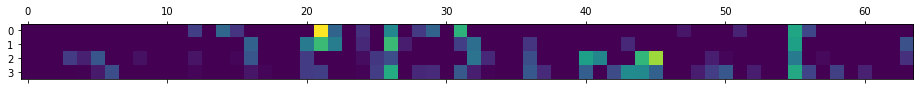

In [141]:
for x in fmaps_pool:
    map_stack = np.hstack(x)
    print(map_stack.shape)
    plt.matshow(map_stack, cmap='viridis')

In [ ]:
img_tensor = np.expand_dims(map_stack, axis=0)

In [ ]:
images_per_row = 6

In [ ]:
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(int(np.ceil(n_cols/images_per_row))):
        for row in range(images_per_row):
            if col * images_per_row + row < n_cols:
                channel_image = layer_activation[0,:, :,col * images_per_row + row]
                display_grid[col * size : (col + 1) * size,row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [ ]:
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(int(np.ceil(n_cols/images_per_row))):
#     for col in range(n_cols):
        for row in range(images_per_row):
            print(col,images_per_row,row)
            print(col * images_per_row + row)
            if col * images_per_row + row < n_cols:
                channel_image = layer_activation[0,:, :,col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')